Please Fill in your name below:

In [ ]:
NAME = "Mohammed Ali Ali ELnagar "

---

# Deep Learning
# Assignment 4: Transfer Learning with MobileNetV2

**Please follow the following instructions for your answers to be graded correctly**:
- Inside the functions, make sure to write your code between the comments "# YOUR CODE STARTS HERE " and "# YOUR CODE ENDS HERE ". **Do not** edit any code outside these comments inside the functions.
- Before you submit your assignment, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

\
In this assignment, you'll be using transfer learning on a pre-trained CNN to build an Alpaca/Not Alpaca classifier!

A pre-trained model is a network that's already been trained on a large dataset and saved, which allows you to use it to customize your own model cheaply and efficiently. The one you'll be using, MobileNetV2, was designed to provide fast and computationally efficient performance. It's been pre-trained on ImageNet, a dataset containing over 14 million images and 1000 classes.

## Table of Content

- [1 - Packages](#1)
    - [1.1 Create the Dataset and Split it into Training and Validation Sets](#1-1)
- [2 - Preprocess and Augment Training Data](#2)
    - [Exercise 1 - data_augmenter](#ex-1)
- [3 - Using MobileNetV2 for Transfer Learning](#3)
    - [3.1 - Inside a MobileNetV2 Convolutional Building Block](#3-1)
    - [3.2 - Layer Freezing with the Functional API](#3-2)
        - [Exercise 2 - alpaca_model](#ex-2)
    - [3.3 - Fine-tuning the Model](#3-3)
        - [Exercise 3](#ex-3)

<a name='1'></a>
## 1 - Packages

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras import Sequential

from tensorflow.keras.preprocessing import image_dataset_from_directory
# from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
from tensorflow.keras.layers import RandomFlip, RandomRotation

<a name='1-1'></a>
### 1.1 Create the Dataset and Split it into Training and Validation Sets

When training and evaluating deep learning models in Keras, generating a dataset from image files stored on disk is simple and fast. Call `image_data_set_from_directory()` to read from the directory and create both training and validation datasets.

If you're specifying a validation split, you'll also need to specify the subset for each portion. Just set the training set to `subset='training'` and the validation set to `subset='validation'`.
See [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory)
for more details and information on directory structure.

You'll also set your seeds to match each other, so your training and validation sets don't overlap. :)

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
directory ="C:/fourth_year/first_semester/deep learing/assignments/assignment4/dataA"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)

Found 2000 files belonging to 2 classes.
Using 1600 files for training.
Found 2000 files belonging to 2 classes.
Using 400 files for validation.


Now let's take a look at some of the images from the training set:

**Note:** The original dataset has some mislabelled images in it as well.

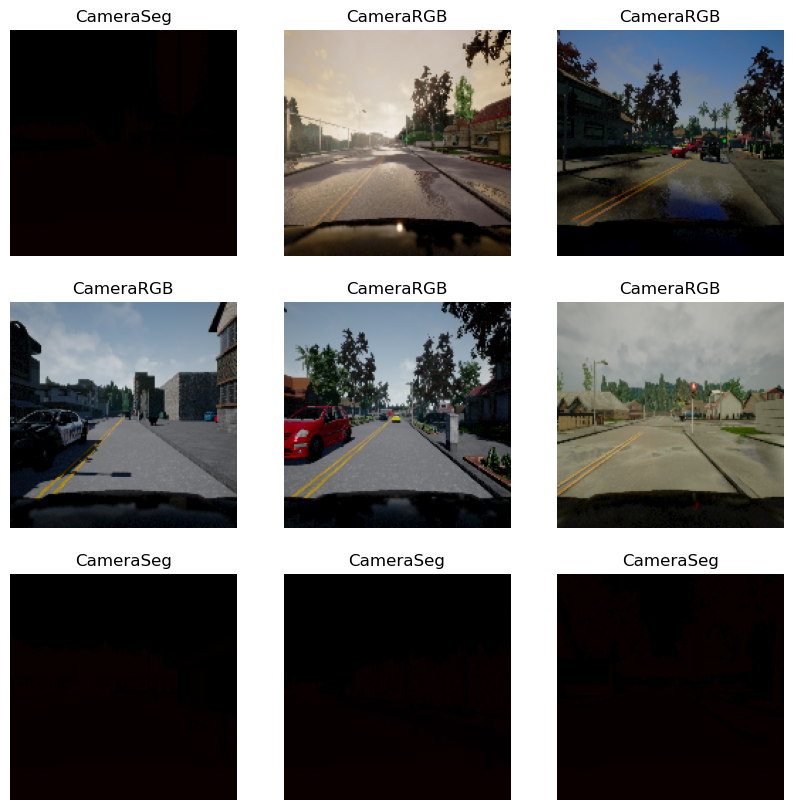

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

<a name='2'></a>
## 2 - Preprocess and Augment Training Data

You may have encountered `dataset.prefetch` in a previous TensorFlow assignment, as an important extra step in data preprocessing.

Using `prefetch()` prevents a memory bottleneck that can occur when reading from disk. It sets aside some data and keeps it ready for when it's needed, by creating a source dataset from your input data, applying a transformation to preprocess it, then iterating over the dataset one element at a time. Because the iteration is streaming, the data doesn't need to fit into memory.

You can set the number of elements to prefetch manually, or you can use `tf.data.experimental.AUTOTUNE` to choose the parameters automatically. Autotune prompts `tf.data` to tune that value dynamically at runtime, by tracking the time spent in each operation and feeding those times into an optimization algorithm. The optimization algorithm tries to find the best allocation of its CPU budget across all tunable operations.

To increase diversity in the training set and help your model learn the data better, it's standard practice to augment the images by transforming them, i.e., randomly flipping and rotating them. Keras' Sequential API offers a straightforward method for these kinds of data augmentations, with built-in, customizable preprocessing layers. These layers are saved with the rest of your model and can be re-used later.

You can read the official docs, which you can find for data augmentation [here](https://www.tensorflow.org/tutorials/images/data_augmentation).


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

<a name='ex-1'></a>
### Exercise 1 - data_augmenter

Implement a function for data augmentation. Use a `Sequential` keras model composed of 2 layers:
* `RandomFlip('horizontal')`
* `RandomRotation(0.2)`

In [ ]:
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''
    # YOUR CODE STARTS HERE
    data_augmentation = Sequential (
        [
           RandomFlip("horizontal"),
           RandomRotation(0.2),

        ]
     )
    # YOUR CODE ENDS HERE

    return data_augmentation

Take a look at how an image from the training set has been augmented with simple transformations:

From one cute animal, to 9 variations of that cute animal, in three lines of code. Now your model has a lot more to learn from.

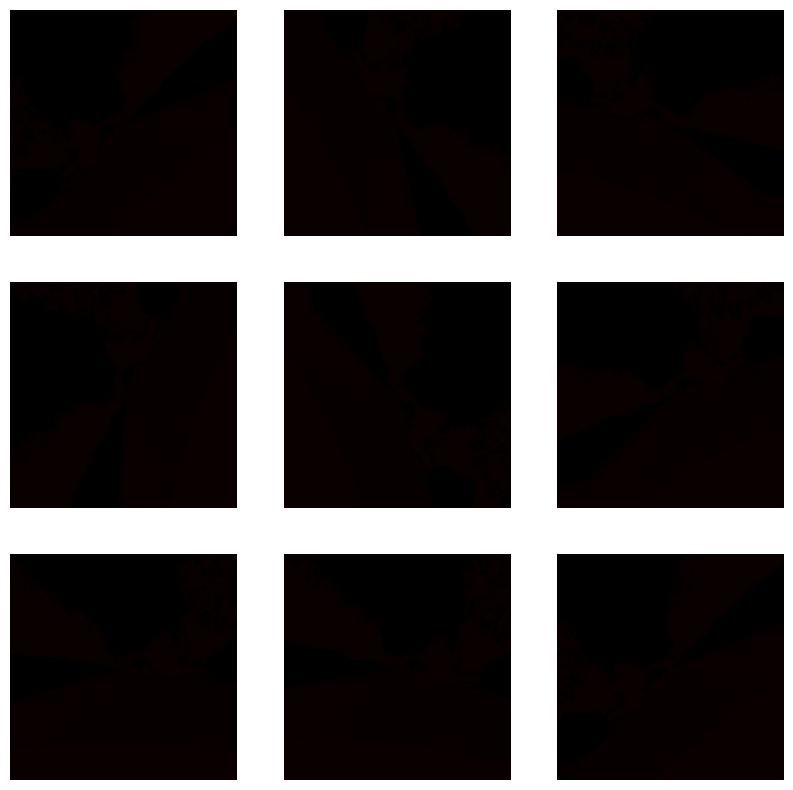

In [ ]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

Next, you'll apply your first tool from the MobileNet application in TensorFlow, to normalize your input. Since you're using a pre-trained model that was trained on the normalization values [-1,1], it's best practice to reuse that standard with tf.keras.applications.mobilenet_v2.preprocess_input.

<font color = 'blue'>

**What you should remember:**

* When calling image_data_set_from_directory(), specify the train/val subsets and match the seeds to prevent overlap
* Use prefetch() to prevent memory bottlenecks when reading from disk
* Give your model more to learn from with simple data augmentations like rotation and flipping.
* When using a pretrained model, it's best to reuse the weights it was trained on.

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

<a name='3'></a>
## 3 - Using MobileNetV2 for Transfer Learning

MobileNetV2 was trained on ImageNet and is optimized to run on mobile and other low-power applications. It's 155 layers deep (just in case you felt the urge to plot the model yourself, prepare for a long journey!) and very efficient for object detection and image segmentation tasks, as well as classification tasks like this one. The architecture has three defining characteristics:

*   Depthwise separable convolutions
*   Thin input and output bottlenecks between layers
*   Shortcut connections between bottleneck layers

<a name='3-1'></a>
### 3.1 - Inside a MobileNetV2 Convolutional Building Block

MobileNetV2 uses depthwise separable convolutions ([blog](https://medium.com/@zurister/depth-wise-convolution-and-depth-wise-separable-convolution-37346565d4ec)) as efficient building blocks. Traditional convolutions are often very resource-intensive, and  depthwise separable convolutions are able to reduce the number of trainable parameters and operations and also speed up convolutions in two steps:

1. The first step calculates an intermediate result by convolving on each of the channels independently. This is the depthwise convolution.

2. In the second step, another convolution merges the outputs of the previous step into one. This gets a single result from a single feature at a time, and then is applied to all the filters in the output layer. This is the pointwise convolution, or: **Shape of the depthwise convolution X Number of filters.**

<img src="https://1.bp.blogspot.com/-M8UvZJWNW4E/WsKk-tbzp8I/AAAAAAAAChw/OqxBVPbDygMIQWGug4ZnHNDvuyK5FBMcQCLcBGAs/s1600/image5.png" style="width:650px;height:450px;">
<caption><center> <u> <font color='purple'> <b>Figure 1</b> </u><font color='purple'>  : <b>MobileNetV2 Architecture</b> <br> <a href="https://1.bp.blogspot.com/-M8UvZJWNW4E/WsKk-tbzp8I/AAAAAAAAChw/OqxBVPbDygMIQWGug4ZnHNDvuyK5FBMcQCLcBGAs/s1600/image5.png."</center></caption>

Each block consists of an inverted residual structure with a bottleneck at each end. These bottlenecks encode the intermediate inputs and outputs in a low dimensional space, and prevent non-linearities from destroying important information.

The shortcut connections, which are similar to the ones in traditional residual networks, serve the same purpose of speeding up training and improving predictions. These connections skip over the intermediate convolutions and connect the bottleneck layers.

Let's try to train your base model using all the layers from the pretrained model.

Similarly to how you reused the pretrained normalization values MobileNetV2 was trained on, you'll also load the pretrained weights from ImageNet by specifying `weights='imagenet'`.

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

Print the model summary below to see all the model's layers, the shapes of their outputs, and the total number of parameters, trainable and non-trainable.

In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 3,538,984 (13.50 MB)

 Trainable params: 3,504,872 (13.37 MB)

 Non-trainable params: 34,112 (133.25 KB)

Note the last 2 layers here. They are the so called top layers, and they are responsible of the classification in the model

In [ ]:
nb_layers = len(base_model.layers)
print(base_model.layers[nb_layers - 2].name)
print(base_model.layers[nb_layers - 1].name)

global_average_pooling2d
predictions


Notice some of the layers in the summary like `Conv2D` and `DepthwiseConv2D` and how they follow the progression of expansion to depthwise convolution to projection. In combination with BatchNormalization and ReLU, these make up the bottleneck layers mentioned earlier.

<font color='blue'>

**What you should remember**:

* MobileNetV2's unique features are:
  * Depthwise separable convolutions that provide lightweight feature filtering and creation
  * Input and output bottlenecks that preserve important information on either end of the block
* Depthwise separable convolutions deal with both spatial and depth (number of channels) dimensions

Next, choose the first batch from the tensorflow dataset to use the images, and run it through the MobileNetV2 base model to test out the predictions on some of your images.

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 1000)


In [ ]:
#Shows the different label probabilities in one tensor
label_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 1])>

Now decode the predictions made by the model. Earlier, when you printed the shape of the batch, it would have returned (32, 1000). The number 32 refers to the batch size and 1000 refers to the 1000 classes the model was pretrained on. The predictions returned by the base model below follow this format:

First the class number, then a human-readable label, and last the probability of the image belonging to that class. You'll notice that there are two of these returned for each image in the batch - these the top two probabilities returned for that image.

In [ ]:
base_model.trainable = False
image_var = tf.Variable(preprocess_input(image_batch))
pred = base_model(image_var)

tf.keras.applications.mobilenet_v2.decode_predictions(pred.numpy(), top=2)

[[('n03196217', 'digital_clock', 0.30271447),
  ('n01930112', 'nematode', 0.13369794)],
 [('n04286575', 'spotlight', 0.07934829),
  ('n03196217', 'digital_clock', 0.06807853)],
 [('n03196217', 'digital_clock', 0.28219602),
  ('n01930112', 'nematode', 0.15674184)],
 [('n03196217', 'digital_clock', 0.15197659),
  ('n04418357', 'theater_curtain', 0.11812556)],
 [('n02965783', 'car_mirror', 0.0946828),
  ('n03388043', 'fountain', 0.06705354)],
 [('n03196217', 'digital_clock', 0.18877636),
  ('n04418357', 'theater_curtain', 0.084978685)],
 [('n03457902', 'greenhouse', 0.10082807),
  ('n09332890', 'lakeside', 0.06331875)],
 [('n04286575', 'spotlight', 0.14166933),
  ('n04418357', 'theater_curtain', 0.033117905)],
 [('n03388043', 'fountain', 0.18464427),
  ('n03776460', 'mobile_home', 0.050029818)],
 [('n04286575', 'spotlight', 0.15398031),
  ('n01930112', 'nematode', 0.08741175)],
 [('n01930112', 'nematode', 0.21562058),
  ('n03196217', 'digital_clock', 0.15047668)],
 [('n03196217', 'digital

Uh-oh. There's a whole lot of labels here, some of them hilariously wrong, but none of them say "alpaca."

This is because MobileNet pretrained over ImageNet doesn't have the correct labels for alpacas, so when you use the full model, all you get is a bunch of incorrectly classified images.

Fortunately, you can delete the top layer, which contains all the classification labels, and create a new classification layer.

<a name='3-2'></a>
### 3.2 - Layer Freezing with the Functional API

In the next sections, you'll see how you can use a pretrained model to modify the classifier task so that it's able to recognize alpacas. You can achieve this in three steps:

1. Delete the top layer (the classification layer)
    * Set `include_top` in `base_model` as False
2. Add a new classifier layer
    * Train only one layer by freezing the rest of the network
    * As mentioned before, a single neuron is enough to solve a binary classification problem.
3. Freeze the base model and train the newly-created classifier layer
    * Set `base model.trainable=False` to avoid changing the weights and train *only* the new layer
    * Set training in `base_model` to False to avoid keeping track of statistics in the batch norm layer

<a name='ex-2'></a>
### Exercise 2 - alpaca_model
steps:
- define base model (MobileNetV2 without the top layer and with the pretrained weights)
- freeze the base model by making it non trainable
- create the input layer (Same as the imageNetv2 input size)
- apply data augmentation to the inputs
- data preprocessing using tf.keras.applications.mobilenet_v2.preprocess_input.
- build your model upon the preprocessed input. Set training to False to avoid keeping track of statistics in the batch norm layer
- add the new Binary classification layers:
    - use global avg pooling to summarize the info in each channel
    - include dropout with probability of 0.2 to avoid overfitting
    - use a prediction layer with one neuron (as a binary classifier only needs one)
    

In [ ]:
def alpaca_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    ''' Define a tf.keras model for binary classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
    Returns:
        tf.keras.model
    '''


    input_shape = image_shape + (3,)

    # YOUR CODE STARTS HERE
    inputs = tf.keras.Input(shape=input_shape)
    if data_augmentation:
        x = data_augmentation(inputs)
    else:
        x = inputs
    base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False
    x = preprocess_input(x)
    x = base_model(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    # YOUR CODE ENDS HERE

    model = tf.keras.Model(inputs, outputs)

    return model

Create your new model using the data_augmentation function defined earlier.

In [ ]:
model2 = alpaca_model(IMG_SIZE, data_augmentation)

The base learning rate has been set for you, so you can go ahead and compile the new model and run it for a few epochs:

In [ ]:
base_learning_rate = 0.001
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
initial_epochs = 5
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/5


c:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\nn.py:707: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


50/50 ━━━━━━━━━━━━━━━━━━━━ 32s 454ms/step - accuracy: 0.7995 - loss: 0.3757 - val_accuracy: 1.0000 - val_loss: 0.0135
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 350ms/step - accuracy: 1.0000 - loss: 0.0067 - val_accuracy: 1.0000 - val_loss: 0.0080
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 319ms/step - accuracy: 1.0000 - loss: 0.0037 - val_accuracy: 1.0000 - val_loss: 0.0056
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 311ms/step - accuracy: 1.0000 - loss: 0.0028 - val_accuracy: 1.0000 - val_loss: 0.0042
Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 345ms/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 1.0000 - val_loss: 0.0032


Plot the training and validation accuracy:

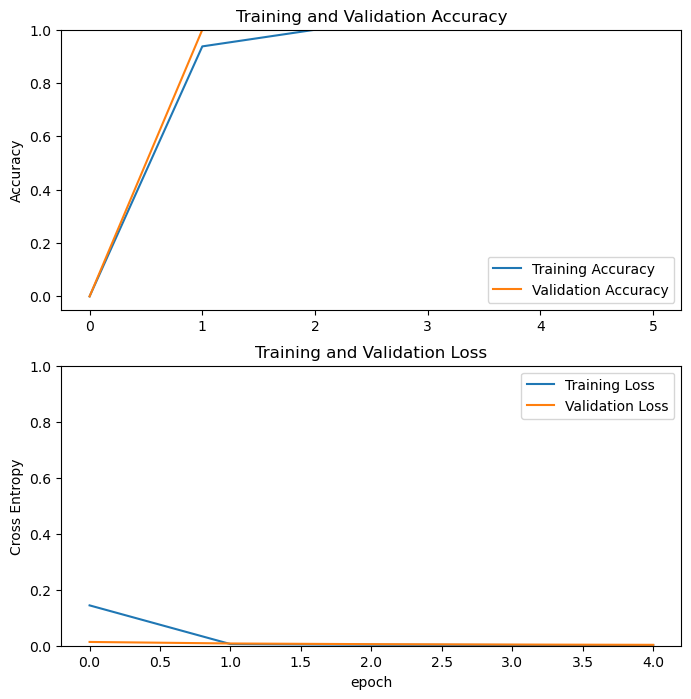

In [ ]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
class_names

['CameraRGB', 'CameraSeg']

The results are ok, but could be better. Next, try some fine-tuning.

<a name='3-3'></a>
### 3.3 - Fine-tuning the Model

You could try fine-tuning the model by re-running the optimizer in the last layers to improve accuracy. When you use a smaller learning rate, you take smaller steps to adapt it a little more closely to the new data. In transfer learning, the way you achieve this is by unfreezing the layers at the end of the network, and then re-training your model on the final layers with a very low learning rate. Adapting your learning rate to go over these layers in smaller steps can yield more fine details - and higher accuracy.

The intuition for what's happening: when the network is in its earlier stages, it trains on low-level features, like edges. In the later layers, more complex, high-level features like wispy hair or pointy ears begin to emerge. For transfer learning, the low-level features can be kept the same, as they have common features for most images. When you add new data, you generally want the high-level features to adapt to it, which is rather like letting the network learn to detect features more related to your data, such as soft fur or big teeth.

To achieve this, just unfreeze the final layers and re-run the optimizer with a smaller learning rate, while keeping all the other layers frozen.

Where the final layers actually begin is a bit arbitrary, so feel free to play around with this number a bit. The important takeaway is that the later layers are the part of your network that contain the fine details (pointy ears, hairy tails) that are more specific to your problem.

First, unfreeze the base model by setting `base_model.trainable=True`, set a layer to fine-tune from, then re-freeze all the layers before it. Run it again for another few epochs, and see if your accuracy improved!

<a name='ex-3'></a>
### Exercise 3

In [ ]:
# UNQ_C3
base_model = model2.layers[2]
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 120

# Freeze all the layers before the `fine_tune_at` layer
# Define a BinaryCrossentropy loss function. Use from_logits=True
# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
# Use accuracy as evaluation metric

# YOUR CODE STARTS HERE
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=True)
base_learning_rate = 0.001  # Define the base learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1 * base_learning_rate)
metrics = ['accuracy']
# YOUR CODE ENDS HERE

model2.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

Number of layers in the base model:  154


In [ ]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 5/10


50/50 ━━━━━━━━━━━━━━━━━━━━ 37s 471ms/step - accuracy: 0.9041 - loss: 0.1901 - val_accuracy: 0.9950 - val_loss: 0.0268
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 449ms/step - accuracy: 1.0000 - loss: 8.3199e-04 - val_accuracy: 0.9950 - val_loss: 0.0242
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 403ms/step - accuracy: 1.0000 - loss: 7.7239e-04 - val_accuracy: 0.9950 - val_loss: 0.0177
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 387ms/step - accuracy: 1.0000 - loss: 4.4090e-04 - val_accuracy: 0.9975 - val_loss: 0.0130
Epoch 9/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 390ms/step - accuracy: 1.0000 - loss: 7.4646e-04 - val_accuracy: 0.9975 - val_loss: 0.0087
Epoch 10/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 429ms/step - accuracy: 1.0000 - loss: 2.5838e-04 - val_accuracy: 1.0000 - val_loss: 0.0063


Ahhh, quite an improvement! A little fine-tuning can really go a long way.

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

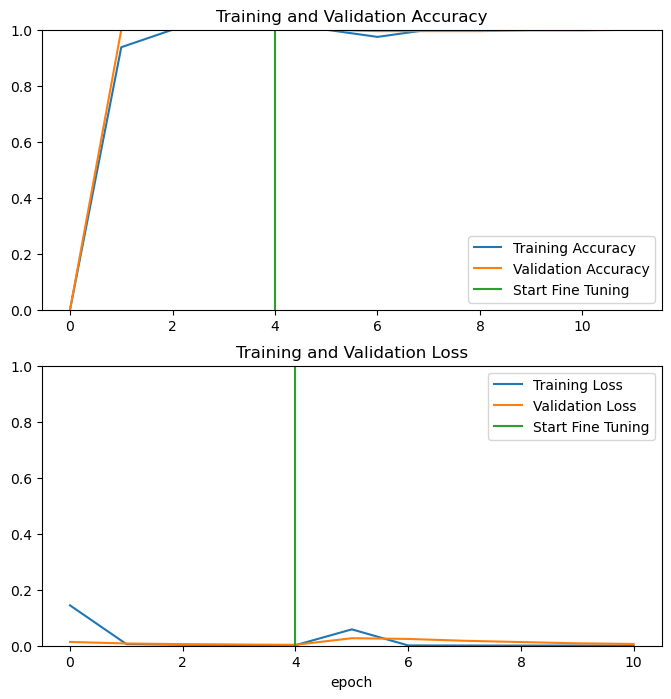

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

<font color='blue'>

**What you should remember**:

* To adapt the classifier to new data: Delete the top layer, add a new classification layer, and train only on that layer
* When freezing layers, avoid keeping track of statistics (like in the batch normalization layer)
* Fine-tune the final layers of your model to capture high-level details near the end of the network and potentially improve accuracy

Congratulations!